In [8]:
from keras.models import Model
from keras.layers import GlobalAveragePooling2D , Dropout , Dense ,Flatten
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD,Adam
from keras.models import load_model
import matplotlib.pyplot as plt

### Compile model [model cheat code](https://towardsdatascience.com/deep-learning-using-transfer-learning-python-code-for-resnet50-8acdfb3a2d38) 

[issue](https://github.com/keras-team/keras/issues/9214) 

In [13]:
CLASSES = 4

In [22]:
base_model = ResNet50(input_shape=(90, 120, 3),weights='imagenet', include_top=False)
x = base_model.output
# x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
#x = Dropout(0.4)(x)
predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

### Load Images

In [15]:
path = "D:/test/dataset/"

In [16]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=15,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.5,
                                   zoom_range=[0.8, 2.0],
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

validate_datagen = ImageDataGenerator(rescale=1./255.)
test_datagen = ImageDataGenerator(rescale=1./255.)

In [17]:
train_generator = train_datagen.flow_from_directory(path+'train/',
                                                  batch_size=10,
                                                    target_size=(90,120),
                                                  class_mode='categorical')

validation_generator = validate_datagen.flow_from_directory(path+'val/',
                                                      batch_size=10,
                                                        target_size=(90,120),
                                                      class_mode='categorical')

test_generator = test_datagen.flow_from_directory(path+'test/',
                                                      batch_size=10,
                                                        target_size=(90,120),
                                                      class_mode='categorical')

Found 424 images belonging to 4 classes.
Found 124 images belonging to 4 classes.
Found 64 images belonging to 4 classes.


### Train model (only the top layers)

In [20]:
for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=["accuracy"])
history = model.fit(
  train_generator,
  validation_data=validation_generator,
  steps_per_epoch=train_generator.n//10,
  epochs=50,
  validation_steps=validation_generator.n//10
)

Epoch 1/50
42/42 [==============================] - 30s 628ms/step - loss: 3.6454 - accuracy: 0.2043 - val_loss: 1.6046 - val_accuracy: 0.4250
Epoch 2/50
42/42 [==============================] - 22s 517ms/step - loss: 1.6132 - accuracy: 0.2832 - val_loss: 1.3210 - val_accuracy: 0.3667
Epoch 3/50
42/42 [==============================] - 22s 521ms/step - loss: 1.4056 - accuracy: 0.3290 - val_loss: 1.4062 - val_accuracy: 0.2417
Epoch 4/50
42/42 [==============================] - 22s 531ms/step - loss: 1.3715 - accuracy: 0.3398 - val_loss: 1.1889 - val_accuracy: 0.4750
Epoch 5/50
42/42 [==============================] - 22s 518ms/step - loss: 1.3219 - accuracy: 0.3364 - val_loss: 1.1815 - val_accuracy: 0.4833
Epoch 6/50
42/42 [==============================] - 22s 525ms/step - loss: 1.3386 - accuracy: 0.3407 - val_loss: 1.1940 - val_accuracy: 0.4917
Epoch 7/50
42/42 [==============================] - 22s 524ms/step - loss: 1.1857 - accuracy: 0.4392 - val_loss: 1.2823 - val_accuracy: 0.3583

### Train (fine-tune bottom 2 layers)

In [23]:
# for layer in model.layers[:168]:
#     layer.trainable = False
# for layer in model.layers[168:]:
#     layer.trainable = True

base_model.trainable = True
set_trainable = False
for layer in base_model.layers:
    if layer.name in ['res5c_branch2b', 'res5c_branch2c', 'activation_97']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

#SGD(lr=0.0001, momentum=0.9)
model.compile(optimizer=Adam(), loss='categorical_crossentropy',metrics=["accuracy"])
history = model.fit(
  train_generator,
  validation_data=validation_generator,
  steps_per_epoch=train_generator.n//10,
  epochs=50,
  validation_steps=validation_generator.n//10
)

Epoch 1/50
42/42 [==============================] - 24s 504ms/step - loss: 2.1944 - accuracy: 0.2887 - val_loss: 1.3474 - val_accuracy: 0.2583
Epoch 2/50
42/42 [==============================] - 20s 473ms/step - loss: 1.2654 - accuracy: 0.3667 - val_loss: 1.1669 - val_accuracy: 0.5333
Epoch 3/50
42/42 [==============================] - 19s 461ms/step - loss: 1.1957 - accuracy: 0.4603 - val_loss: 1.2690 - val_accuracy: 0.5750
Epoch 4/50
42/42 [==============================] - 20s 478ms/step - loss: 1.1884 - accuracy: 0.5399 - val_loss: 1.2831 - val_accuracy: 0.4667
Epoch 5/50
42/42 [==============================] - 31s 754ms/step - loss: 1.1180 - accuracy: 0.4826 - val_loss: 1.0215 - val_accuracy: 0.5667
Epoch 6/50
42/42 [==============================] - 33s 779ms/step - loss: 1.1982 - accuracy: 0.4620 - val_loss: 1.0122 - val_accuracy: 0.6000
Epoch 7/50
42/42 [==============================] - 36s 855ms/step - loss: 1.1417 - accuracy: 0.5107 - val_loss: 1.2024 - val_accuracy: 0.4167

### Evaluate model & Visualize performance

In [24]:
model.evaluate(test_generator)

7/7 [==============================] - 4s 538ms/step - loss: 0.5276 - accuracy: 0.7812


[0.5276222825050354, 0.78125]

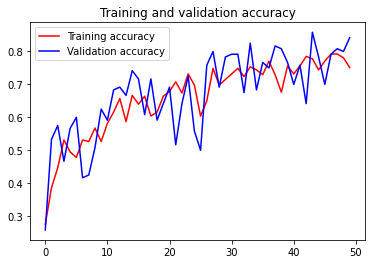

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
fig = plt.gcf()
fig.savefig('from_ResNet50.png',dpi=fig.dpi)
plt.show()



### Save model

In [26]:
model.save('from_ResNet50.h5')
model.save_weights('from_ResNet50_weights.h5')